# Waveform fitting

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv1-ll


## This notebook is for prototyping and scratch code only. Please see scripts with same issue number.

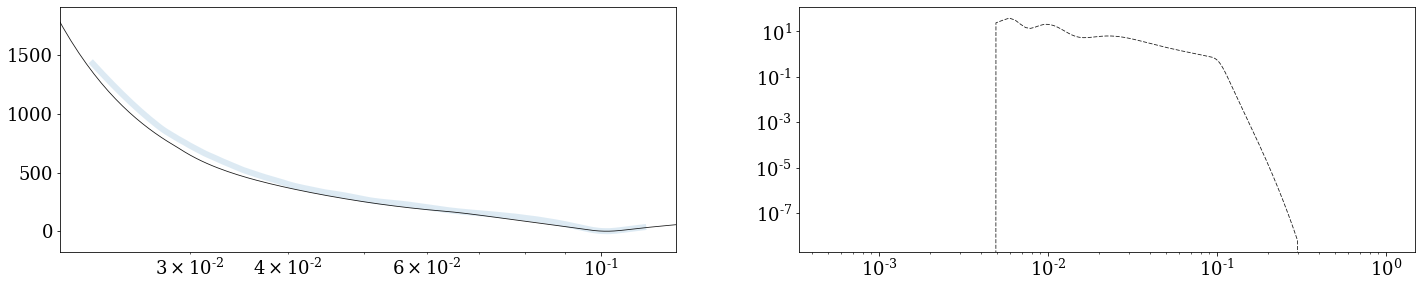

In [44]:

#
from numpy.linalg import norm
from scipy.optimize import curve_fit

#
datadir = '/Users/book/KOALA/PhenomXCP/data/version2/'
files = glob( datadir+'*.txt' )

#
# fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*len(files) ]) )
fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 1.5*1 ]) )
ax = ax.flatten()

#
# tight_layout(1,2,4)

#
foo = {}

#
lmlist = [ (2,2) ]

#
p = 0
for f_ in files[::-1]:
    
    if 'q8a08t30' in f_:#'q8a08t30' in f_:

        #
        simname = f_.split('/')[-1].split('.')[0]

        # Find index location of metadata for simname 
        k = list( metadata_dict['simname'] ).index(simname)

        # Load data for this case
        raw_data = loadtxt(f_).T
        calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data )

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_vec,chi2_vec = metadata_dict['array_data'][k]
        dphi_fd -= min( dphi_fd[ (f>0.03)&(f<0.12) ] )
        
        #
        freqs,mod_phenomd_dict = xcp.phenomxhm_multipoles( lmlist, m1, m2, chi1_vec, chi2_vec )
        mod_phenomd = mod_phenomd_dict[2,2]
        mod_phenomd_amp = abs(mod_phenomd)
        mod_phenomd_phi = unwrap( angle(mod_phenomd) )
        mod_phenomd_dphi = spline_diff(freqs,mod_phenomd_phi)
        mod_phenomd_dphi -= min( mod_phenomd_dphi[ (freqs>0.03)&(freqs<0.12) ] )

#         # GENERATE TEMPLATE FUNCTIONS
#         # ---
#         template_amp, template_dphi, template_phi = pwca.template_amp_phase(m1, m2, chi1, chi2, chi_p)
        

#         # PHASE 
#         # ---

#         #
#         phenomd_phi = template_phi(f)
#         phi_popt, phi_pcov = curve_fit(template_phi, f, phi_td,p0=[0,0,0,0])
#         best_fit_phi = template_phi(f,*phi_popt)

#         # PHASE DERIVATIVE
#         # ---

#         #
#         phenomd_dphi = template_dphi(f)
#         dphi_popt, dphi_pcov = curve_fit(template_dphi, f, dphi_td,p0=[0,0,0,0])
#         best_fit_dphi = template_dphi(f,*dphi_popt)
#         best_fit_dphi2 = template_dphi(f,*phi_popt)
#         best_fit_phi_from_dphi_fit = template_phi(f,*dphi_popt)

#         # AMPLITUDE
#         # ---

#         #
#         amp_scale = f ** (7.0/6)
#         inv_amp_scale = f ** (-7.0/6)

#         #
#         log_scaled_template_amp = lambda X,MU0,MU1,MU2,MU3,MU4: log(  template_amp(X,MU0,MU1,MU2,MU3,MU4)*amp_scale  )
#         phenomd_amp = template_amp(f)

#         #
#         scaled_amp_fd = amp_fd * amp_scale
#         log_scaled_amp_fd = log(scaled_amp_fd)
#         log_scaled_amp_popt, log_amp_pcov = curve_fit(log_scaled_template_amp, f, log_scaled_amp_fd,p0=[0,0,0,0,0])
#         best_fit_amp = exp(log_scaled_template_amp(f,*log_scaled_amp_popt)) * inv_amp_scale

#         # PLOTTING
#         # ---


#         #figure( figsize=1.5*figaspect(0.5*0.618/2) )

#         #subplot(1,2,1)
        sca(ax[p]); p+=1
#         #plot( f, phenomd_dphi, label='PhenomD', ls='--',alpha=0.3,color='k' )
        plot( f, dphi_fd, label='NR', lw=6, alpha=0.15 )
        plot( freqs, mod_phenomd_dphi, label='ModPhenomD', ls='-',alpha=0.9,color='k' )
        xscale('log')
        xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
        ylim( limy(freqs, mod_phenomd_dphi,dilate=0.1) )
#         plot( f, best_fit_dphi, label='Best Fit', color='r', ls='-' )
#         #plot( f, best_fit_dphi2, label='Best Fit (phi fit)', color='b', ls='-' )
#         title(simname,size=12,loc='left')
#         legend(ncol=3,loc=1)
#         ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
#         if p==(len(files)-2):  xlabel('$fM$')
#         #
#         title(f_.split('/')[-1].split('.')[0],loc='left',size=12)

#         #subplot(1,2,2)
        sca(ax[p]); p+=1
        plot( freqs, mod_phenomd_amp, label='ModPhenomD', ls='--',alpha=0.9,color='k' )
#         plot( f, phenomd_amp, label='PhenomD', ls='--',alpha=0.9,color='k' )
#         plot( f, amp_fd, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
#         plot( f, best_fit_amp, label='Best Fit', color='r', ls='-' )
#         title(simname,size=12,loc='left')
        yscale('log')
        xscale('log')
#         legend(ncol=3,loc=3)
#         ylabel(r'$|\tilde{h}_{22}(f)|$')
#         #
#         title(f_.split('/')[-1].split('.')[0],loc='left',size=12)
        
#         #
#         figure()
#         mask = (f>0.03) & (f<0.12)
#         plot( f, phenomd_phi, label='PhenomD', ls='--',alpha=0.9,color='k' )
#         plot( f, phi_td, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
#         plot( f, best_fit_phi, label='Best Fit', color='r', ls='-' )
#         plot( f, best_fit_phi_from_dphi_fit, label='Best Fit 2', color='b', ls='-' )

#         figure()
#         plot( f,best_fit_phi-phi_td, label='from phase fit' )
#         plot( f,best_fit_phi_from_dphi_fit-phi_td, label='from dphase fit' )
#         legend()
        
        #
        break
        
    

In [43]:
??lim

Signature: lim(x, dilate=0, dilate_with_multiply=False)
Source:   
def lim(x,dilate=0,dilate_with_multiply=False):
    '''
    Return the min and max limits of an 1D array.

    INPUT
    ---
    x,              ndarray
    dilate=0,       fraction of max-min by which to expand or contract output

    RETURN
    ---
    array with [min(x),max(x)]

    '''

    # Import useful bit
    from numpy import array,amin,amax,ndarray,diff

    # ensure is array
    if not isinstance(x,ndarray): x = array(x)
    
    # Validate
    if dilate_with_multiply:
        if not dilate:
            error('for dilate_with_multiply to have effect, the dilate keyword must be set to a number')

    # Columate input.
    z = x.reshape((x.size,))

    #
    ans = array([min(z),max(z)]) + (0 if len(z)>1 else array([-1e-20,1e-20]))

    #
    if dilate != 0: 
        if dilate_with_multiply:
            abs_dilate = abs(dilate)
            dilate = max( abs_dilate, 1.0/abs_dilate )
            ans *= array([1.0

In [16]:
print around( dphi_popt, 4 )
print around( phi_popt, 4 )
print abs(phi_popt-dphi_popt)

[ 0.19    0.0212  0.0073 -0.5444]
[ 0.183   0.0205  0.0065 -0.4279]
[0.00697128 0.00066231 0.00078652 0.11649948]


In [24]:
# ?curve_fit

In [3]:
?spline_diff

Signature: spline_diff(t, y, k=3, n=1)
Docstring: Wrapper for InterpolatedUnivariateSpline derivative function
File:      ~/JOKI/Libs/KOALA/positive_dev/positive/maths.py
Type:      function


In [ ]:

figure()

for d in data:
    
    f,amp_td,amp_fd,dphi_td,dphi_fd = d.T
    
    plot( f, dphi_td-min(dphi_td) )

(-0.7266398012230191, 731.7166240000845)

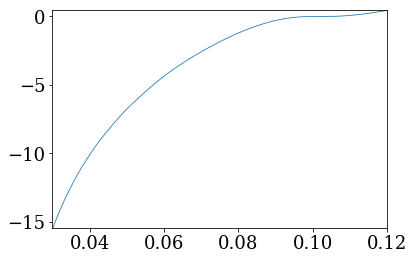

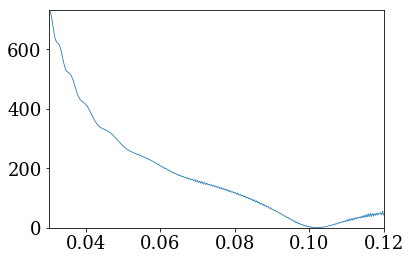

In [43]:
f,_,_,_,_,phi_td,_ = raw_data

#
fmin,fmax = 0.03,0.12

figure()
plot( f, phi_td )
xlim(fmin,fmax)
ylim( lim(phi_td[(f>fmin)&(f<fmax)]) )

#
dphi = spline_diff(f,phi_td)
# shift = 

figure()
plot( f, dphi )
xlim(0.03,0.12)
ylim( lim(dphi[(f>fmin)&(f<fmax)]) )

In [97]:
from scipy.optimize import minimize

In [99]:
# ?minimize